# Value-based Agent using PyTorch

In [1]:
import copy
import time
import torch
import imageio
import gymnasium as gym
import matplotlib.pyplot as plt

from agents import ValueDeepQAgent

## Cart-pole environment

|        | TYPE             | VALUES | DESCRIPTION                                                                     |
|--------|------------------|--------|---------------------------------------------------------------------------------|
| Action | ndarray<br/>(1,) | {0, 1} | Direction to push cart.<br/>0: left<br/>1: right                                |
| Observation | ndarray<br/>(4,) | float  | 1. Cart position<br/>2. Cart velocity<br/>3. Pole angle<br/>4. Angular velocity |
| Reward |  | float | Reward is given for every step taken, including the termination step.<br/>Each step provides a reward of +1 |
| Termination &<br/>Truncation |  | boolean | Pole Angle exceeds ± 0.2095 rad<br/>Cart Position exceeds ± 2.4 (i.e., edge of the display)<br/>Episode length is greater than 500 |

In [2]:
environment = gym.make('CartPole-v1', render_mode="rgb_array")

### Training

In [3]:
GAMES = 10000

INPUTS = 4
OUTPUTS = 2
NODES = [15, 30]

ALPHA = 0.95
EXPLORATION_RATE = 1.0
EXPLORATION_DECAY = 0.999
EXPLORATION_MIN = 0.01
OPTIMIZER = {"optim": torch.optim.RMSprop, "lr": 0.00025}

RESET_Q = 250

In [4]:
value_agent = ValueDeepQAgent(
    network={"inputs": INPUTS, "outputs": OUTPUTS, "nodes": NODES},
    optimizer=OPTIMIZER,
    alpha=ALPHA,
    exploration_rate=EXPLORATION_RATE, exploration_decay=EXPLORATION_DECAY, exploration_min=EXPLORATION_MIN
)

_value_agent = copy.deepcopy(value_agent)

In [5]:
checkpoint = GAMES // 10
metrics = {"steps": torch.zeros(GAMES), "losses": torch.zeros(GAMES)}

In [6]:
start = time.time()
for game in range(1, GAMES + 1):
    
    state = torch.tensor(environment.reset()[0], dtype=torch.float32).unsqueeze(0)  # noqa
    terminated = truncated = False
    
    # LEARNING FROM GAME
    # --------------------------------------------------
    
    steps = 0
    while not (terminated or truncated):
        steps += 1
        action = value_agent.action(state)
        new_state, reward, terminated, truncated, _ = environment.step(action.item())
        new_state = torch.tensor(new_state, dtype=torch.float32).unsqueeze(0)

        value_agent.memorize(state, action, new_state, torch.tensor([reward]))
        state = new_state
    
    loss = value_agent.learn(network=_value_agent)
    
    if game % RESET_Q == 0:
        _value_agent = copy.deepcopy(value_agent)

    # METRICS
    # --------------------------------------------------
    
    metrics["steps"][game-1] = steps
    metrics["losses"][game-1] = loss
    
    if game % checkpoint == 0 or game == GAMES:

        _mean_steps = metrics["steps"][max(0, game-checkpoint-1):game-1].mean()
        _mean_loss = metrics["losses"][max(0, game-checkpoint-1):game-1].mean()
        
        print(f"Game {game:>6} {int(game/GAMES * 100):>16} % \n"
              f"{'-'*30} \n"
              f" > Average steps: {int(_mean_steps):>12} \n"
              f" > Average loss: {_mean_loss:>13.4f} \n ")
        
print(f"Total training time: {time.time()-start:.2f} seconds")

Game   1000               10 % 
------------------------------ 
 > Average steps:           15 
 > Average loss:        0.1625 
 
Game   2000               20 % 
------------------------------ 
 > Average steps:           10 
 > Average loss:        0.2079 
 
Game   3000               30 % 
------------------------------ 
 > Average steps:            9 
 > Average loss:        0.3552 
 
Game   4000               40 % 
------------------------------ 
 > Average steps:            9 
 > Average loss:        0.5298 
 
Game   5000               50 % 
------------------------------ 
 > Average steps:            9 
 > Average loss:        0.8675 
 
Game   6000               60 % 
------------------------------ 
 > Average steps:            9 
 > Average loss:        1.2638 
 
Game   7000               70 % 
------------------------------ 
 > Average steps:            9 
 > Average loss:        1.6762 
 
Game   8000               80 % 
------------------------------ 
 > Average steps:         

#### Visualisation

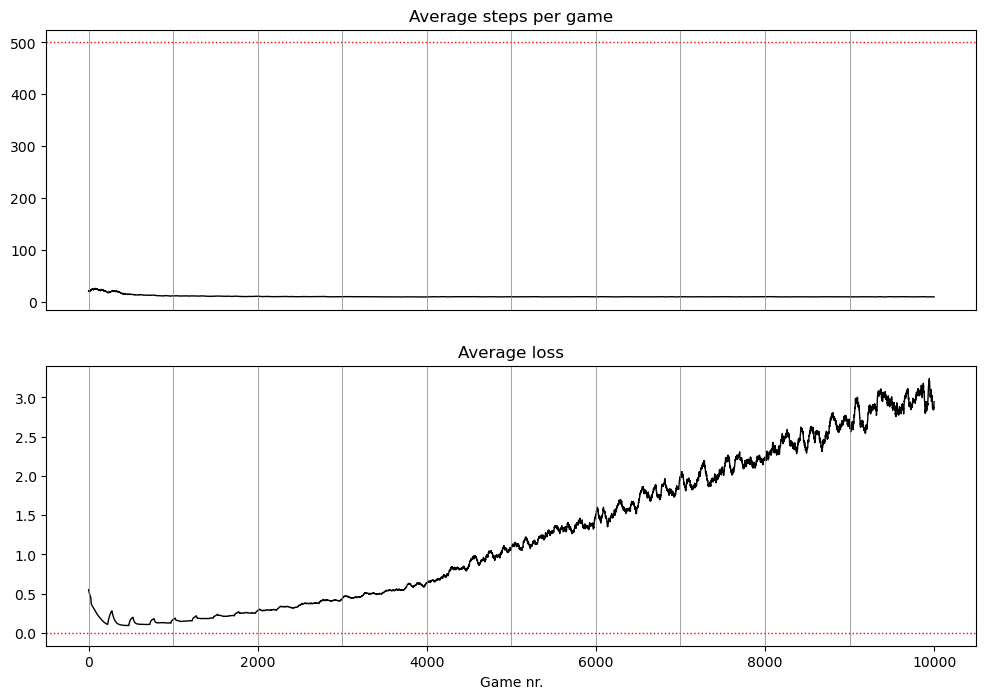

In [7]:
def moving_average(data, window_size=50):
    """Compute moving average with given window size of the data."""
    half_window = window_size // 2
    return [(data[max(0, i-half_window):min(GAMES, i+half_window)]).mean() 
            for i in range(GAMES)]

steps = moving_average(metrics["steps"])
losses = moving_average(metrics["losses"])

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].axhline(y=500, color="red", linestyle="dotted", linewidth=1)
ax[0].plot(steps, color="black", linewidth=1)
ax[0].set_xticks([])
ax[0].set_title("Average steps per game")

ax[1].axhline(y=0, color="red", linestyle="dotted", linewidth=1)
ax[1].plot(losses, color="black", linewidth=1)
ax[1].set_xlabel("Game nr.")
ax[1].set_title("Average loss")

for i in range(0, GAMES, 1000):
    ax[0].axvline(x=i, color='gray', linewidth=0.5)
    ax[1].axvline(x=i, color='gray', linewidth=0.5)

plt.show()

##### In action

In [8]:
state = torch.tensor(environment.reset()[0], dtype=torch.float32)

images = []
terminated = truncated = False
while not (terminated or truncated):
    action = torch.argmax(value_agent(state)).item()
    
    state, reward, terminated, truncated, _ = environment.step(action)
    state = torch.tensor(state, dtype=torch.float32)

    images.append(environment.render())
_ = imageio.mimsave('./a-cart-pole.gif', images, duration=25)

<img src="./a-cart-pole.gif" width="400" height="400" />

In [9]:
environment.close()

## (Atari) Breakout environment

| | TYPE  | VALUES       | DESCRIPTION |
|--------|------------------|--------------|-------------|
| Action | ndarray<br/>(1,) | {0, 1, 2, 3} | 0: noop<br/>1: fire<br/>2: right<br/> 3: left |
| Observation | ndarray<br/>(210,160) | int          | Grayscale image of screen |
| Reward |   | int          | Reward depends on brick colour<br/>Red: 7<br/>Orange: 7<br/>Yellow: 4<br/>Green: 4<br/>Aqua: 1<br/>Blue: 1 |
| Termination |   | bool         | Timer: score as many points within the given time |